Load all relevant libraries

In [25]:
# Data manipulation and numerical computing
import numpy as np
import pandas as pd


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_error

# Statistical analysis
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Data processing
from datetime import datetime
import re

Load the quarterly data file

In [3]:
# Load the CSV file
file_path = "Quarterly Data.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Info:")
print(df.info())

# Show the first few rows
print("\nFirst 5 Rows:")
print(df.head())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())
for i in df.columns:
    print(i)
    

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Columns: 246 entries, sasdate to S&P PE ratio
dtypes: float64(244), int64(1), object(1)
memory usage: 509.4+ KB
None

First 5 Rows:
     sasdate     GDPC1   PCECC96    PCDGx     PCESVx     PCNDx   GPDIC1  \
0    factors     0.000     0.000   1.0000     1.0000    1.0000    0.000   
1  transform     5.000     5.000   5.0000     5.0000    5.0000    5.000   
2   3/1/1959  3352.129  2039.017  68.6651  1374.1739  689.1172  354.894   
3   6/1/1959  3427.667  2070.508  71.2495  1394.7096  694.8197  382.500   
4   9/1/1959  3430.057  2092.138  72.6270  1413.6627  697.4699  357.798   

       FPIx  Y033RC1Q027SBEAx     PNFIx  ...  TNWMVBSNNCBBDIx   TLBSNNBx  \
0    0.0000            1.0000    1.0000  ...             0.00       0.00   
1    5.0000            5.0000    5.0000  ...             2.00       5.00   
2  357.0174           47.8021  171.0783  ...          1341.67  333245.24   
3  368.0640           49.23

Creating a contraction variable

In [4]:
df = pd.read_csv(file_path, skiprows=[1,2])

# Ensure the date column is parsed as datetime
df['sasdate'] = pd.to_datetime(df['sasdate'], format='%m/%d/%Y')

# Create the contraction variable
# 0 if GDP decreased, 1 if it increased, NaN for the first term
df['contraction'] = df['GDPC1'].diff().apply(lambda x: 0 if x < 0 else 1 if x > 0 else None)

# Display the resulting DataFrame
print(df.head(10))

     sasdate     GDPC1   PCECC96    PCDGx     PCESVx     PCNDx   GPDIC1  \
0 1959-03-01  3352.129  2039.017  68.6651  1374.1739  689.1172  354.894   
1 1959-06-01  3427.667  2070.508  71.2495  1394.7096  694.8197  382.500   
2 1959-09-01  3430.057  2092.138  72.6270  1413.6627  697.4699  357.798   
3 1959-12-01  3439.832  2094.495  69.1573  1430.8157  701.7617  369.442   
4 1960-03-01  3517.181  2114.532  71.3815  1443.7405  703.5338  406.581   
5 1960-06-01  3498.246  2141.205  73.0060  1459.7419  711.2267  368.686   
6 1960-09-01  3515.385  2132.646  72.4230  1458.0198  707.0772  367.749   
7 1960-12-01  3470.278  2135.408  70.6037  1472.0544  707.5612  327.010   
8 1961-03-01  3493.703  2134.615  66.7214  1486.5082  711.7757  335.496   
9 1961-06-01  3553.021  2166.382  68.1057  1508.2076  721.3207  359.004   

       FPIx  Y033RC1Q027SBEAx     PNFIx  ...   TLBSNNBx  TLBSNNBBDIx  \
0  357.0174           47.8021  171.0783  ...  333245.24    266668.11   
1  368.0640           49.2332 

shift the recessions value back by 3 months

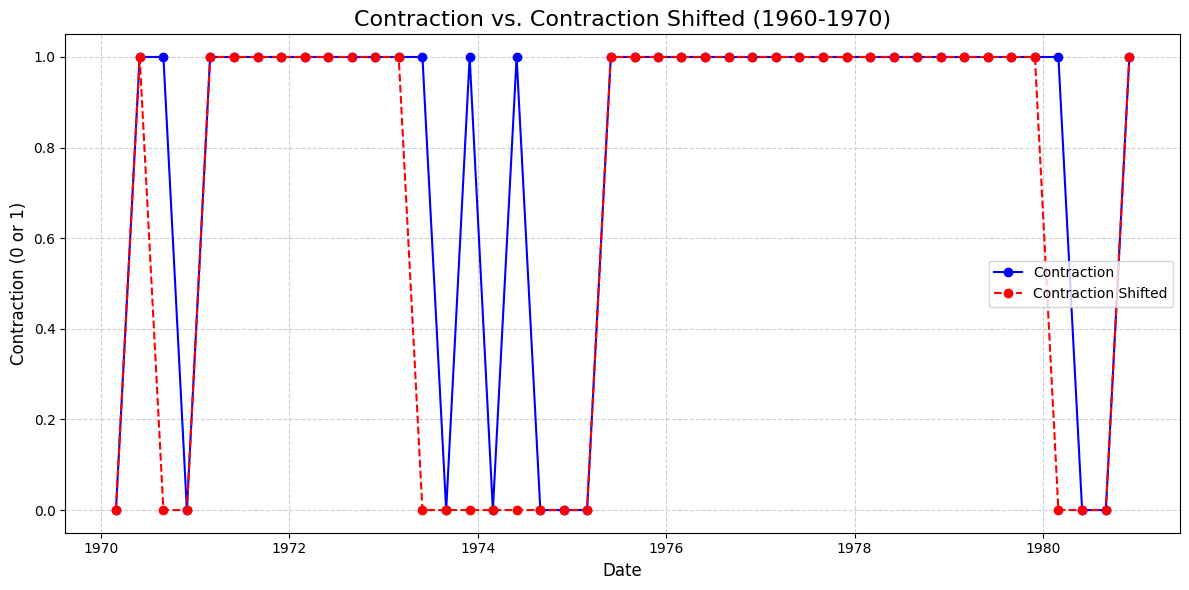

In [5]:
# Create a new column for shifted contraction
df['contraction_shifted'] = 1  # Initialize with 1 (non-contraction)

# Iterate through rows to adjust the contraction periods
for i in range(1, len(df)):
    # If a contraction starts (1 → 0), shift the start back by one quarter
    if df.loc[i - 1, 'contraction'] == 1 and df.loc[i, 'contraction'] == 0:
        if i - 1 > 0:  # Ensure we're not out of bounds
            df.loc[i - 1, 'contraction_shifted'] = 0  # Start earlier
        df.loc[i, 'contraction_shifted'] = 0  # Maintain real-time contraction

    # If within a contraction period (0), keep the contraction
    elif df.loc[i, 'contraction'] == 0:
        df.loc[i, 'contraction_shifted'] = 0

# Filter the data for visualization (e.g., 1960–1970)
df_filtered = df[(df['sasdate'] >= '1970-01-01') & (df['sasdate'] <= '1980-12-31')]

# Plot the results
plt.figure(figsize=(12, 6))

# Plot original contraction
plt.plot(
    df_filtered['sasdate'],
    df_filtered['contraction'],
    label='Contraction',
    marker='o',
    linestyle='-',
    color='blue'
)

# Plot shifted contraction
plt.plot(
    df_filtered['sasdate'],
    df_filtered['contraction_shifted'],
    label='Contraction Shifted',
    marker='o',
    linestyle='--',
    color='red'
)

# Add labels, legend, and grid
plt.title('Contraction vs. Contraction Shifted (1960-1970)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Contraction (0 or 1)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

In [6]:

# Define your dependent (target) and independent (predictor) variables
target = "PCECC96"  # Real Personal Consumption Expenditures (Chained 2012 Dollars)
predictors = ["CPIAUCSL", "UMCSENTx", "FEDFUNDS", "DPIC96", "UNRATE"]

# Ensure the date column is in datetime format if not already
df["sasdate"] = pd.to_datetime(df["sasdate"])

# Split data into training (1959Q1–2000Q4) and validation (2001Q1–2012Q4)
train_df = df[(df["sasdate"] >= "1959-01-01") & (df["sasdate"] <= "2009-12-31")]
val_df = df[(df["sasdate"] >= "2010-01-01") & (df["sasdate"] <= "2024-12-31")]

# Extract X (independent variables) and Y (dependent variable) for training
X_train = train_df[predictors]
y_train = train_df[target]




X_train['UMCSENTx'] = X_train['UMCSENTx'].fillna(method='ffill')
X_train['UMCSENTx'] = X_train['UMCSENTx'].fillna(method='bfill')

print(X_train.isna().sum())  # Check for NaNs in training data



CPIAUCSL    0
UMCSENTx    0
FEDFUNDS    0
DPIC96      0
UNRATE      0
dtype: int64


/tmp/ipykernel_2329/1333108981.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train['UMCSENTx'] = X_train['UMCSENTx'].fillna(method='ffill')
/tmp/ipykernel_2329/1333108981.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['UMCSENTx'] = X_train['UMCSENTx'].fillna(method='ffill')
/tmp/ipykernel_2329/1333108981.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train['UMCSENTx'] = X_train['UMCSENTx'].fillna(method='bfill')
/tmp/ipykernel_2329/1333108981.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [7]:
# Extract X (independent variables) and Y (dependent variable) for validation
X_val = val_df[predictors]
y_val = val_df[target]

# Add a constant to include an intercept in the regression
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)

# Fit the OLS Regression Model
model = sm.OLS(y_train, X_train).fit()

# Print model summary
print(model.summary())

# Make predictions on validation set
y_pred = model.predict(X_val)

# Evaluate model performance
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mape = (abs(y_val - y_pred) / y_val).mean() * 100  # MAPE formula

print("\nValidation Set Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")



                            OLS Regression Results                            
Dep. Variable:                PCECC96   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.716e+04
Date:                Sun, 09 Feb 2025   Prob (F-statistic):          3.71e-292
Time:                        15:45:11   Log-Likelihood:                -1211.8
No. Observations:                 204   AIC:                             2436.
Df Residuals:                     198   BIC:                             2455.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -86.3768    108.239     -0.798      0.4

In [8]:
import pandas as pd

# Load the OECD Monthly Business Confidence Data
oecd_file_path = "OECD.SDD.STES,DSD_STES@DF_CLI,+USA.M.BCICP...AA...H.csv"
oecd_data = pd.read_csv(oecd_file_path, encoding="latin1")

# Load the Quarterly Dataset (for date reference and consistency)
quarterly_file_path = "Quarterly Data.csv"
quarterly_data = pd.read_csv(quarterly_file_path, encoding="latin1")

# Convert Date Column in OECD Data
oecd_data['sasdate'] = pd.to_datetime(oecd_data['TIME_PERIOD'], errors='coerce')

# Extract relevant columns (Date and Business Confidence Index)
oecd_data = oecd_data[['sasdate', 'OBS_VALUE']]
oecd_data.rename(columns={'OBS_VALUE': 'Business_Confidence'}, inplace=True)

# Resample to Quarterly: Take the first available value of each quarter
oecd_quarterly = oecd_data.set_index('sasdate').resample('Q').first().reset_index()

# Ensure consistency with the quarterly dataset (Start from 1959)
oecd_quarterly = oecd_quarterly[oecd_quarterly['sasdate'] >= "1959-01-01"]

print(oecd_quarterly.head())

# Adjust the quarterly dates to follow the format: 12-01, 3-01, 6-01, 9-01

# First, ensure the quarterly data is in datetime format
oecd_quarterly['sasdate'] = pd.to_datetime(oecd_quarterly['sasdate'])

# Modify the day of the date to match the desired quarterly format (12-01, 3-01, 6-01, 9-01)
oecd_quarterly['sasdate'] = oecd_quarterly['sasdate'].apply(lambda x: pd.Timestamp(year=x.year, month=x.month, day=1))

# Adjust the month so that quarters match 12-01 (Q4), 3-01 (Q1), 6-01 (Q2), 9-01 (Q3)
oecd_quarterly['sasdate'] = oecd_quarterly['sasdate'].apply(lambda x: 
    x.replace(month=12) if x.month == 10 else 
    x.replace(month=3) if x.month == 1 else 
    x.replace(month=6) if x.month == 4 else 
    x.replace(month=9) if x.month == 7 else x)

# Save the updated dataset with correct quarterly dates
output_path_adjusted = "OECD_Quarterly_Business_Confidence_Adjusted.csv"
oecd_quarterly.to_csv(output_path_adjusted, index=False)

# Display confirmation message
print(f"Adjusted OECD Quarterly Business Confidence data saved to: {output_path_adjusted}")

# Remove the last two entries (for 12-01-2024 and 03-01-2025)
oecd_quarterly = oecd_quarterly.iloc[:-2]

# Save the updated dataset without the last two entries
output_path_final = "OECD_Quarterly_Business_Confidence_Final.csv"
oecd_quarterly.to_csv(output_path_final, index=False)

# Display confirmation message
print(f"Final OECD Quarterly Business Confidence data (adjusted) saved to: {output_path_final}")

# Ensure the OECD data column is named correctly
oecd_quarterly.rename(columns={'Business_Confidence': 'BCIUSA'}, inplace=True)

# Merge with the existing df on 'sasdate'
df = pd.merge(df, oecd_quarterly, on='sasdate', how='left')
df["BCIUSA"] = df["BCIUSA_y"]
df.drop(columns=["BCIUSA_x", "BCIUSA_y"], inplace=True)

print(df.head())



/tmp/ipykernel_2329/3676629156.py:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  oecd_quarterly = oecd_data.set_index('sasdate').resample('Q').first().reset_index()


      sasdate  Business_Confidence
36 1959-03-31            102.47640
37 1959-06-30            103.19420
38 1959-09-30            101.52760
39 1959-12-31             99.43076
40 1960-03-31            100.81220
Adjusted OECD Quarterly Business Confidence data saved to: OECD_Quarterly_Business_Confidence_Adjusted.csv
Final OECD Quarterly Business Confidence data (adjusted) saved to: OECD_Quarterly_Business_Confidence_Final.csv


KeyError: 'BCIUSA_y'

In [14]:
import pandas as pd

#===============================================================================
# 1. Read the annual corporate tax data
#===============================================================================
fctax_annual = pd.read_csv("FCTAX (1).csv")

# Example columns: [observation_date, FCTAX]
fctax_annual['observation_date'] = pd.to_datetime(fctax_annual['observation_date'], errors='coerce')

# Extract year, ensuring it's integer
fctax_annual['year'] = fctax_annual['observation_date'].dt.year
# Convert to numeric, drop invalid rows, cast to int
fctax_annual['year'] = pd.to_numeric(fctax_annual['year'], errors='coerce')
fctax_annual.dropna(subset=['year'], inplace=True)
fctax_annual['year'] = fctax_annual['year'].astype(int)

# Just keep [year, FCTAX] for clarity (if you have other columns, you can keep them as needed)
fctax_annual = fctax_annual[['year', 'FCTAX']]

#===============================================================================
# 2. Convert annual FCTAX -> quarterly rows
#    (Here we "repeat" the annual value in each quarter; if you prefer to split
#     the annual total across 4 quarters, use val/4 below.)
#===============================================================================
quarters_data = []
for idx, row in fctax_annual.iterrows():
    yr = row['year'].astype(int)       # this is now an integer
    val = row['FCTAX']     # float or int, doesn't matter for repeating
    
    q_starts = [
        pd.Timestamp(yr,  1, 1),  # Q1 start
        pd.Timestamp(yr,  4, 1),  # Q2 start
        pd.Timestamp(yr,  7, 1),  # Q3 start
        pd.Timestamp(yr, 10, 1),  # Q4 start
    ]
    
    for q_date in q_starts:
        quarters_data.append([q_date, val])  # repeating annual value

fctax_quarterly = pd.DataFrame(quarters_data, columns=['sasdate', 'FCTAX'])

#===============================================================================
# 3. Shift each quarter by 2 months (Jan->Mar, Apr->Jun, Jul->Sep, Oct->Dec)
#===============================================================================
fctax_quarterly['sasdate'] = fctax_quarterly['sasdate'] + pd.DateOffset(months=2)

#===============================================================================
# 4. Drop rows before 1959-03-01 and sort by date
#===============================================================================
cutoff_date = pd.to_datetime('1959-03-01')
fctax_quarterly = fctax_quarterly[fctax_quarterly['sasdate'] >= cutoff_date].copy()
fctax_quarterly.sort_values('sasdate', inplace=True)

#===============================================================================
# 5. Merge with your main DataFrame "df"
#    (Ensure df has a 'sasdate' column in matching format)
#===============================================================================
df['sasdate'] = pd.to_datetime(df['sasdate'])  # parse if not already datetime
df_merged = pd.merge(df, fctax_quarterly, on='sasdate', how='left')

# At this point, df_merged has the new 'FCTAX' column at quarterly frequency,
# aligned to sasdate = 3/1, 6/1, 9/1, 12/1 starting in 1959Q1 (Mar).
#===============================================================================

# OPTIONAL: Inspect or save
print(df_merged.head(10))
print(df_merged.tail(10))
# df_merged.to_csv("df_with_FCTAX_quarterly.csv", index=False)


     sasdate     GDPC1   PCECC96    PCDGx     PCESVx     PCNDx   GPDIC1  \
0 1959-03-01  3352.129  2039.017  68.6651  1374.1739  689.1172  354.894   
1 1959-06-01  3427.667  2070.508  71.2495  1394.7096  694.8197  382.500   
2 1959-09-01  3430.057  2092.138  72.6270  1413.6627  697.4699  357.798   
3 1959-12-01  3439.832  2094.495  69.1573  1430.8157  701.7617  369.442   
4 1960-03-01  3517.181  2114.532  71.3815  1443.7405  703.5338  406.581   
5 1960-06-01  3498.246  2141.205  73.0060  1459.7419  711.2267  368.686   
6 1960-09-01  3515.385  2132.646  72.4230  1458.0198  707.0772  367.749   
7 1960-12-01  3470.278  2135.408  70.6037  1472.0544  707.5612  327.010   
8 1961-03-01  3493.703  2134.615  66.7214  1486.5082  711.7757  335.496   
9 1961-06-01  3553.021  2166.382  68.1057  1508.2076  721.3207  359.004   

       FPIx  Y033RC1Q027SBEAx     PNFIx  ...  TNWBSNNBx  TNWBSNNBBDIx  \
0  357.0174           47.8021  171.0783  ...    2092.54       1674.48   
1  368.0640           49.233

In [26]:
import pandas as pd

fctax_quarterly.reset_index(inplace=True)

fctax_quarterly['sasdate'] = pd.to_datetime(fctax_quarterly['sasdate'])

# Suppose fctax_quarterly has columns ['sasdate', 'FCTAX']
# Convert sasdate to datetime if not already done:
fctax_quarterly['sasdate'] = pd.to_datetime(fctax_quarterly['sasdate'])

# Set as index
fctax_quarterly.set_index('sasdate', inplace=True)

# Optionally, force a 3-month frequency starting in March:
fctax_quarterly = fctax_quarterly.asfreq('3MS', method='pad')







# Choose ARIMA orders (p,d,q) and seasonal orders (P,D,Q,4)
model = SARIMAX(
    fctax_quarterly['FCTAX'],
    order=(1,1,0),            # example: ARIMA(1,1,0)
    seasonal_order=(0,1,0,4), # example: seasonal differencing
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())



                                     SARIMAX Results                                     
Dep. Variable:                             FCTAX   No. Observations:                  260
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 4)   Log Likelihood               -1093.406
Date:                           Sun, 09 Feb 2025   AIC                           2190.811
Time:                                   15:54:38   BIC                           2197.886
Sample:                               03-01-1959   HQIC                          2193.657
                                    - 12-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0   1.05e-09          0      1.000   -2.05e-09    2.05e-09
sigma2       321.0562      9.240     34.745

In [29]:
fctax_quarterly.reset_index(inplace=True)
# Now fctax_quarterly has columns ['sasdate', 'FCTAX']

df['sasdate'] = pd.to_datetime(df['sasdate'])                # ensure datetime
fctax_quarterly['sasdate'] = pd.to_datetime(fctax_quarterly['sasdate'])

df = pd.merge(
    df, 
    fctax_quarterly, 
    on='sasdate',        # common key
    how='left'           # keep all rows from df, fill FCTAX where matching
)


In [30]:
# Define your dependent (target) and independent (predictor) variables
target = "GPDIC1"  # Gross Private Domestic Investment (Chained 2012 Dollars)
predictors = ["FEDFUNDS", "BCIUSA", "BUSLOANSx", "USEPUINDXM", "CNCFx", "FCTAX" ]  # Interest rate, business confidence, credit availability, policy uncertainty

# Ensure the date column is in datetime format if not already
df["sasdate"] = pd.to_datetime(df["sasdate"])

# Split data into training (1959Q1–2009Q4) and validation (2010Q1–2024Q4)
train_df = df[(df["sasdate"] >= "1959-01-01") & (df["sasdate"] <= "2009-12-31")]
val_df = df[(df["sasdate"] >= "2010-01-01") & (df["sasdate"] <= "2024-12-31")]

# Extract X (independent variables) and Y (dependent variable) for training
X_train = train_df[predictors]
y_train = train_df[target]

# Handle missing values for predictors (forward fill and backward fill)
for predictor in predictors:
    X_train[predictor] = X_train[predictor].fillna(method="ffill").fillna(method="bfill")

print(X_train.isna().sum())  # Check for NaNs in training data

# Extract X (independent variables) and Y (dependent variable) for validation
X_val = val_df[predictors]
y_val = val_df[target]

# Handle missing values for predictors in validation set
for predictor in predictors:
    X_val[predictor] = X_val[predictor].fillna(method="ffill").fillna(method="bfill")

# Add a constant to include an intercept in the regression
X_train = sm.add_constant(X_train)
X_val = sm.add_constant(X_val)

# Fit the OLS Regression Model
model = sm.OLS(y_train, X_train).fit()

# Print model summary
print("\nInvestment Expenditure Regression Model Summary:")
print(model.summary())

# Make predictions on validation set
y_pred = model.predict(X_val)

# Evaluate model performance
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mape = (abs(y_val - y_pred) / y_val).mean() * 100  # MAPE formula

# Display performance metrics
print("\nValidation Set Performance Metrics for Investment Expenditure:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


FEDFUNDS      0
BCIUSA        0
BUSLOANSx     0
USEPUINDXM    0
CNCFx         0
FCTAX         0
dtype: int64

Investment Expenditure Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 GPDIC1   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1006.
Date:                Sun, 09 Feb 2025   Prob (F-statistic):          7.78e-145
Time:                        15:55:58   Log-Likelihood:                -1287.0
No. Observations:                 204   AIC:                             2588.
Df Residuals:                     197   BIC:                             2611.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

/tmp/ipykernel_2329/4074478944.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train[predictor] = X_train[predictor].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_2329/4074478944.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[predictor] = X_train[predictor].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_2329/4074478944.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_val[predictor] = X_val[predictor].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_2329/4074478944.py:28: SettingWithCopyWarning: 
A value i